In [10]:
%cd torchspdnet_untouched 

# %cd torchspdnet

import os, sys
sys.path.append(os.getcwd())

[Errno 2] No such file or directory: 'torchspdnet_untouched'
/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched


In [11]:
# Preliminaries 
import numpy as np
import pandas as pd
import time

from random import randint
import os
import shutil

from numpy import sqrt 
import torch as th
from scipy.stats import t
import sys

from datetime import datetime
from datetime import timedelta
import missingno as msno

# Enable anomaly detection
th.autograd.set_detect_anomaly(True)

import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

import networkx as nx
from scipy.spatial.distance import squareform

from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
random.seed(27)

import torch.nn as nn
from torch.utils import data

import torchspdnet.nn as spdnet
from torchspdnet.optimizers import MixOptimizer

from collections import Counter

In [12]:
df = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 0)
market_cap = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 1)

df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
market_cap['Dates'] = pd.to_datetime(market_cap['Dates'], infer_datetime_format=True)

df.index = df['Dates']
del df['Dates']
df = df.sort_index()

market_cap.index = market_cap['Dates']
del market_cap['Dates']
market_cap = market_cap.sort_index()

returns = df.pct_change(periods=1)
returns.tail()

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2023-12-07,-0.023719,0.000000,0.000000,-0.040570,-0.061489,-0.010539,0.001028,0.036961,-0.034783,0.026879,...,0.020618,0.000705,-0.052000,-0.025654,0.019185,0.000000,-0.014184,-0.015575,0.000077,-0.021780
2023-12-08,-0.063146,0.000000,-0.010000,-0.028571,0.029310,0.009941,-0.133194,-0.049505,-0.008108,-0.003209,...,0.016547,0.014085,-0.008439,0.015449,-0.005490,0.000000,-0.012950,0.010513,0.004461,0.013804
2023-12-11,-0.002443,0.004800,-0.055556,0.027353,0.005025,0.013359,-0.041542,-0.004167,0.023978,0.019262,...,-0.005290,0.006944,-0.025532,-0.018918,0.000000,0.009730,0.026239,0.003030,0.008347,0.001757
2023-12-12,-0.022229,0.000398,0.016043,-0.020613,0.000000,-0.014571,-0.075673,0.031381,0.039915,-0.017824,...,-0.035456,0.006897,0.029774,-0.023193,0.005521,-0.004283,0.003551,-0.005841,-0.006303,-0.020754
2023-12-13,0.003468,0.005173,0.000000,0.013739,0.000000,0.010562,0.007184,-0.002028,-0.011941,-0.009217,...,0.010886,-0.000685,0.001542,-0.000414,-0.019608,-0.005366,-0.004246,-0.005774,0.005120,0.004627


In [4]:
column_names = list(returns.columns)

# Printing column names to copy
print(column_names)

['ABG SJ Equity', 'ADH SJ Equity', 'AEL SJ Equity', 'AFE SJ Equity', 'AFH SJ Equity', 'AFT SJ Equity', 'AGL SJ Equity', 'AIL SJ Equity', 'AIP SJ Equity', 'AMS SJ Equity', 'ANG SJ Equity', 'ANH SJ Equity', 'APN SJ Equity', 'ARI SJ Equity', 'ARL SJ Equity', 'ATT SJ Equity', 'AVI SJ Equity', 'BAT SJ Equity', 'BAW SJ Equity', 'BHG SJ Equity', 'BID SJ Equity', 'BLU SJ Equity', 'BTI SJ Equity', 'BTN SJ Equity', 'BVT SJ Equity', 'BYI SJ Equity', 'CFR SJ Equity', 'CLS SJ Equity', 'CML SJ Equity', 'COH SJ Equity', 'CPI SJ Equity', 'CSB SJ Equity', 'DCP SJ Equity', 'DRD SJ Equity', 'DSY SJ Equity', 'DTC SJ Equity', 'EMI SJ Equity', 'EQU SJ Equity', 'EXX SJ Equity', 'FBR SJ Equity', 'FFA SJ Equity', 'FFB SJ Equity', 'FSR SJ Equity', 'FTB SJ Equity', 'GFI SJ Equity', 'GLN SJ Equity', 'GND SJ Equity', 'GRT SJ Equity', 'HAR SJ Equity', 'HCI SJ Equity', 'HDC SJ Equity', 'HMN SJ Equity', 'HYP SJ Equity', 'IMP SJ Equity', 'INL SJ Equity', 'INP SJ Equity', 'ITE SJ Equity', 'JSE SJ Equity', 'KAP SJ Equit

In [13]:
import pandas as pd
import numpy as np

# Assuming df and market_cap have been read and processed as per your initial snippet

dates_to_remove = [pd.to_datetime('2006-12-31'), pd.to_datetime('2013-01-01')]

# Remove the dates to remove from both dataframes
returns = returns[~returns.index.isin(dates_to_remove)]
market_cap = market_cap[~market_cap.index.isin(dates_to_remove)]

# Define the start and end of the test period
test_period_start = pd.to_datetime('2007-01-01')
test_period_end = pd.to_datetime('2012-12-31')

# Split data into test and train datasets based on the period, for both df and market_cap
test_df = returns.loc[test_period_start:test_period_end]
returns = pd.concat([returns.loc[:test_period_start - pd.Timedelta(days=1)], returns.loc[test_period_end + pd.Timedelta(days=1):]])

test_market_cap = market_cap.loc[test_period_start:test_period_end]
market_cap = pd.concat([market_cap.loc[:test_period_start - pd.Timedelta(days=1)], market_cap.loc[test_period_end + pd.Timedelta(days=1):]])

# Calculate the cutoff index to retain only the first 90% of the test dataset
cut_off_index_df = int(len(test_df) * 0.9)
cut_off_index_market_cap = int(len(test_market_cap) * 0.9)

# Apply the cutoff to both test datasets
test_returns = test_df.iloc[:cut_off_index_df]
test_market_cap = test_market_cap.iloc[:cut_off_index_market_cap]

# Now, you have train_df and test_df for your model's inputs, along with corresponding train_market_cap and test_market_cap for any additional analysis.


In [14]:
test_returns

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2007-01-01,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,...,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000
2007-01-02,0.015188,0.000000,0.000000,0.011867,NaN,0.000000,0.013012,NaN,NaN,0.001133,...,NaN,NaN,0.010672,0.001873,0.000000,NaN,-0.027368,NaN,-0.000685,-0.003886
2007-01-03,-0.007874,0.000000,-0.008499,-0.000869,NaN,-0.005128,-0.038389,NaN,NaN,-0.021003,...,NaN,NaN,-0.003496,-0.007788,-0.000482,NaN,0.000000,NaN,-0.006169,-0.012828
2007-01-04,-0.024921,-0.016130,0.000000,-0.014493,NaN,-0.001031,-0.016419,NaN,NaN,-0.036949,...,NaN,NaN,0.021052,-0.004710,-0.022824,NaN,0.000000,NaN,-0.006483,-0.006213
2007-01-05,0.006837,-0.009843,-0.014286,-0.007353,NaN,0.000000,0.002869,NaN,NaN,-0.002475,...,NaN,NaN,0.003436,-0.012618,0.022857,NaN,0.001082,NaN,-0.014300,0.000567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-18,-0.015360,0.007875,0.007223,-0.007670,NaN,-0.010187,-0.011457,NaN,-0.012969,-0.010060,...,NaN,NaN,-0.024949,-0.004878,-0.024997,NaN,0.001251,-0.024390,-0.031496,-0.016530
2012-05-21,0.009933,0.000000,0.002390,0.001189,NaN,0.005146,-0.005739,NaN,0.001266,-0.006362,...,NaN,NaN,-0.003356,-0.001225,0.008544,NaN,0.013741,0.031000,0.009756,0.001244
2012-05-22,0.006337,-0.070318,0.003180,-0.002375,NaN,-0.010239,0.024925,NaN,0.004901,0.000266,...,NaN,NaN,0.007155,0.006135,0.000000,NaN,-0.014171,0.013579,0.022544,0.010363


In [6]:
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)

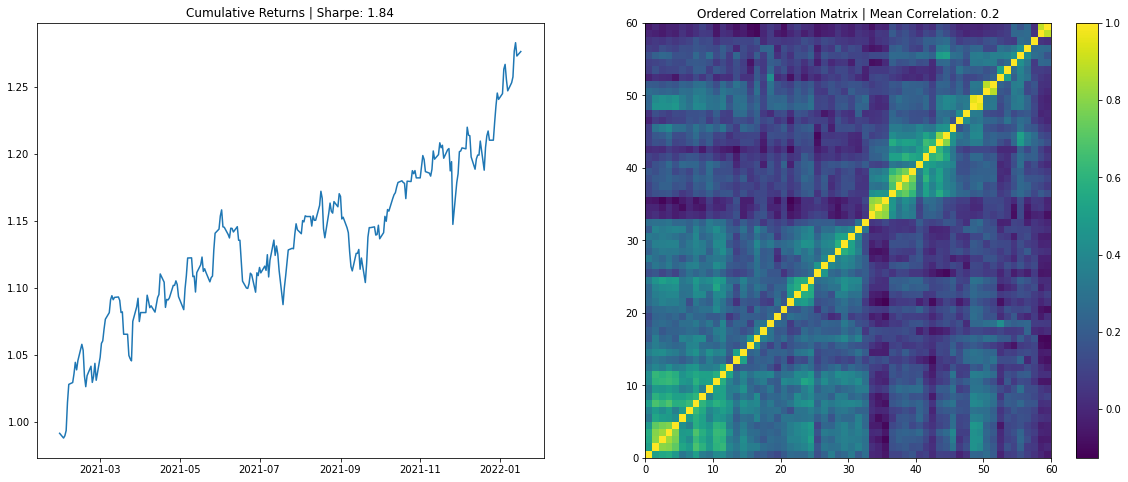

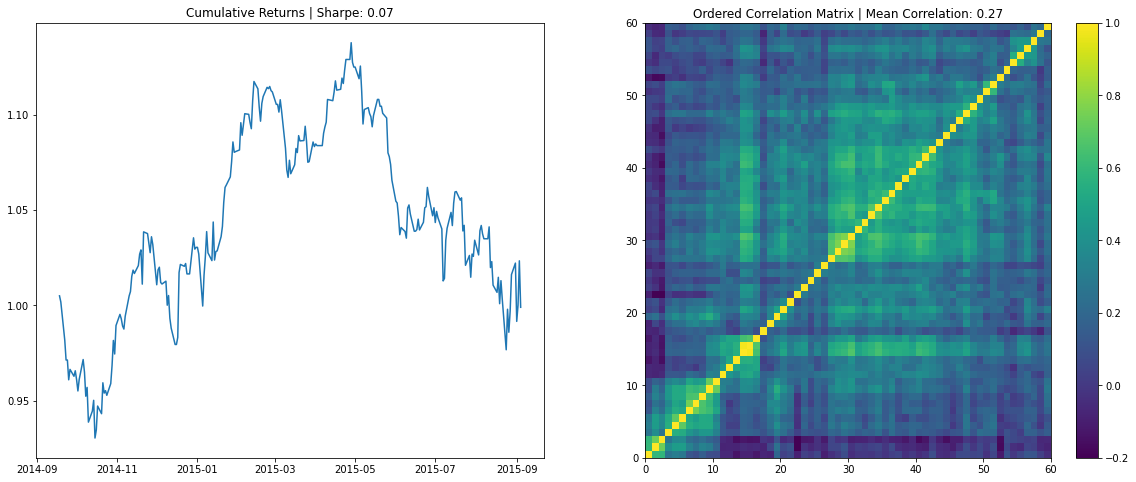

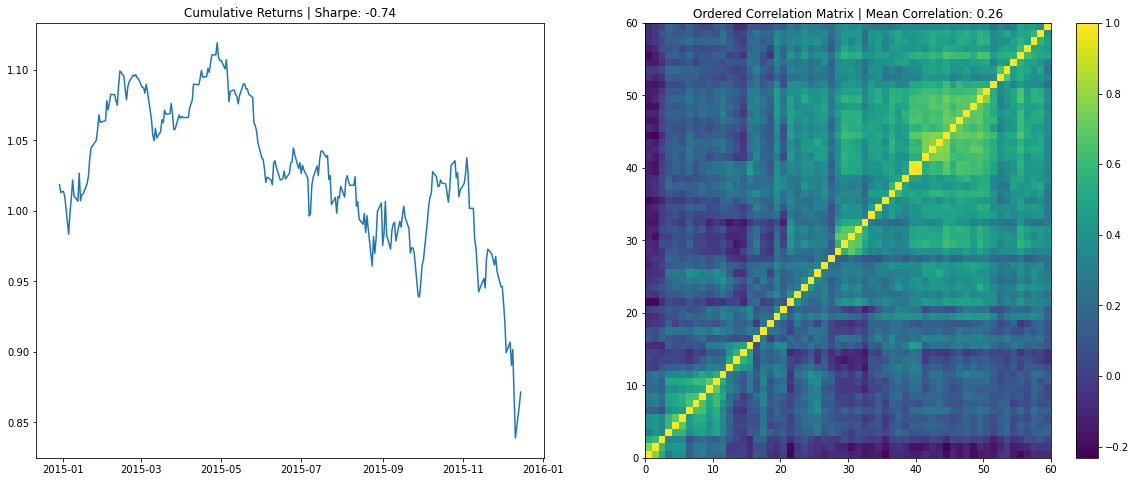

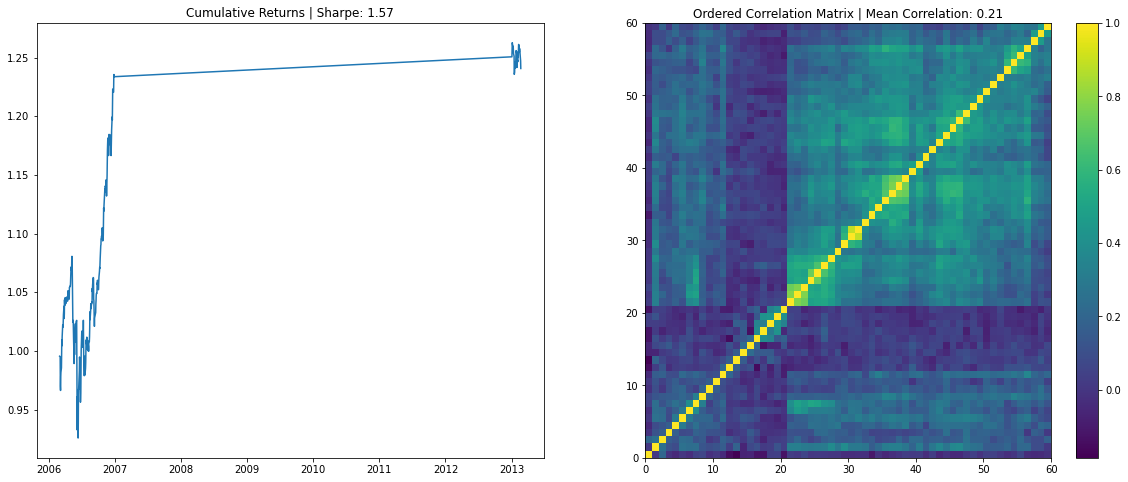

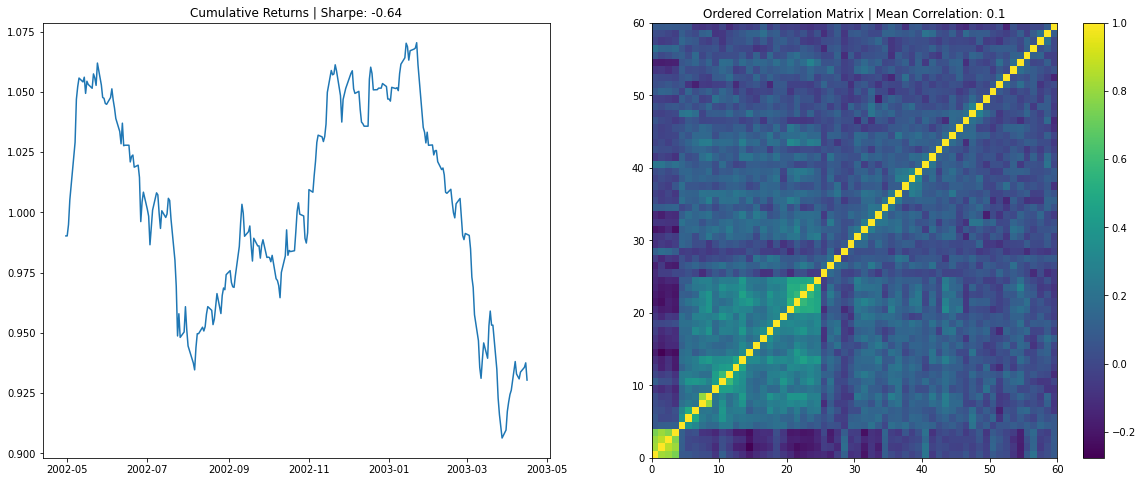

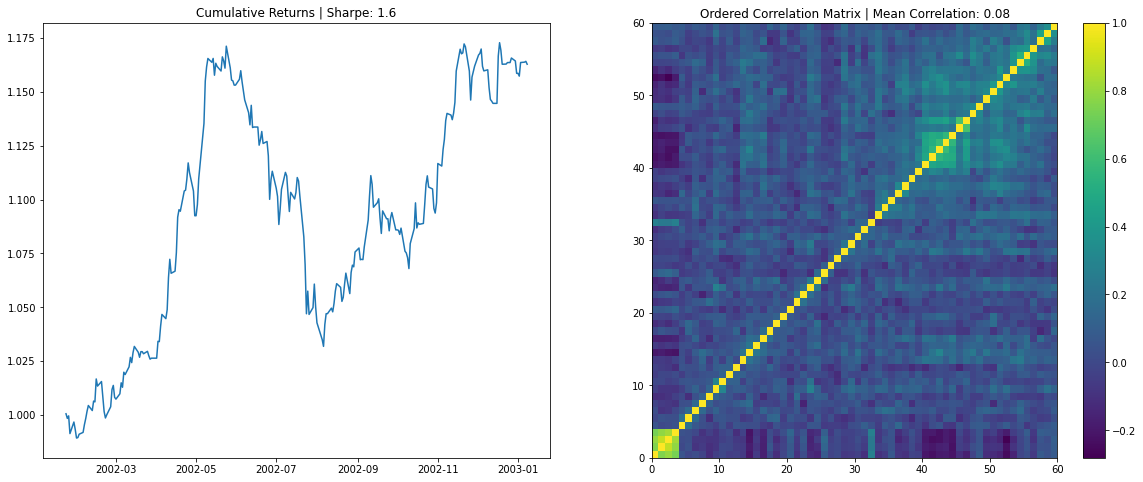

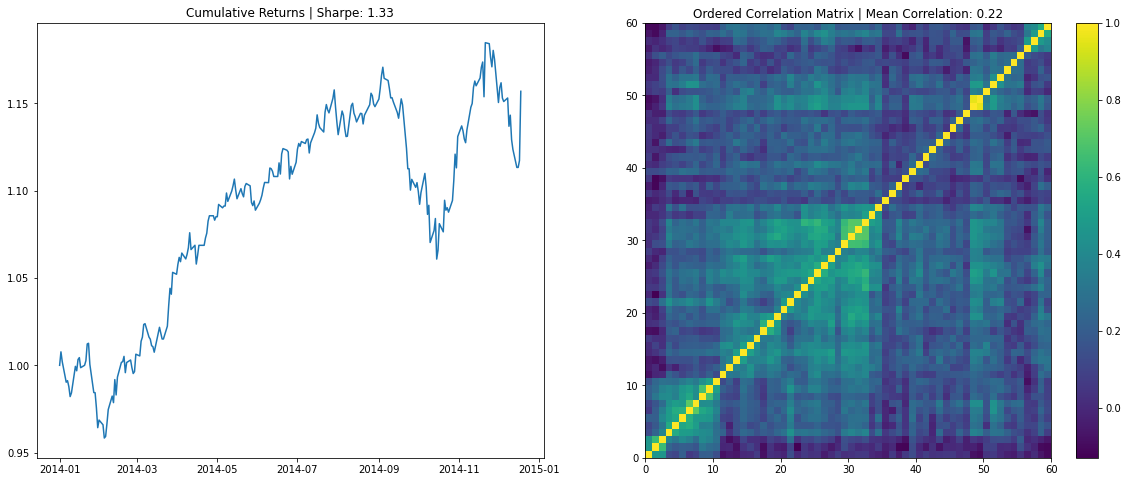

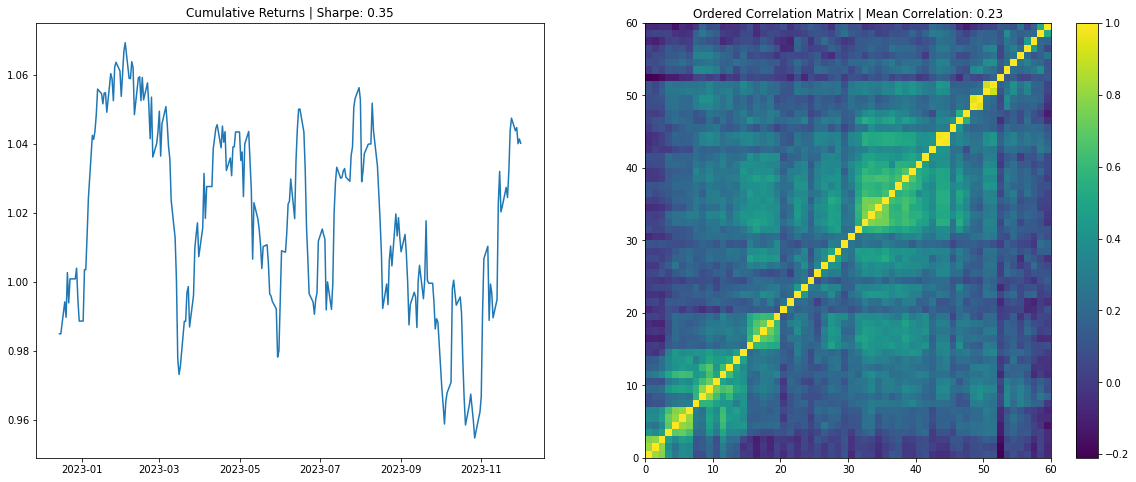

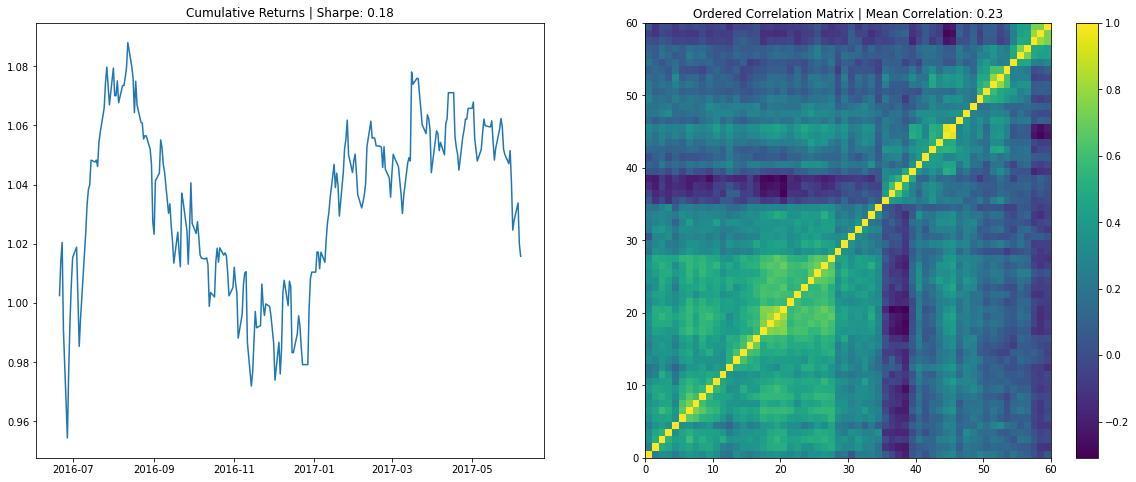

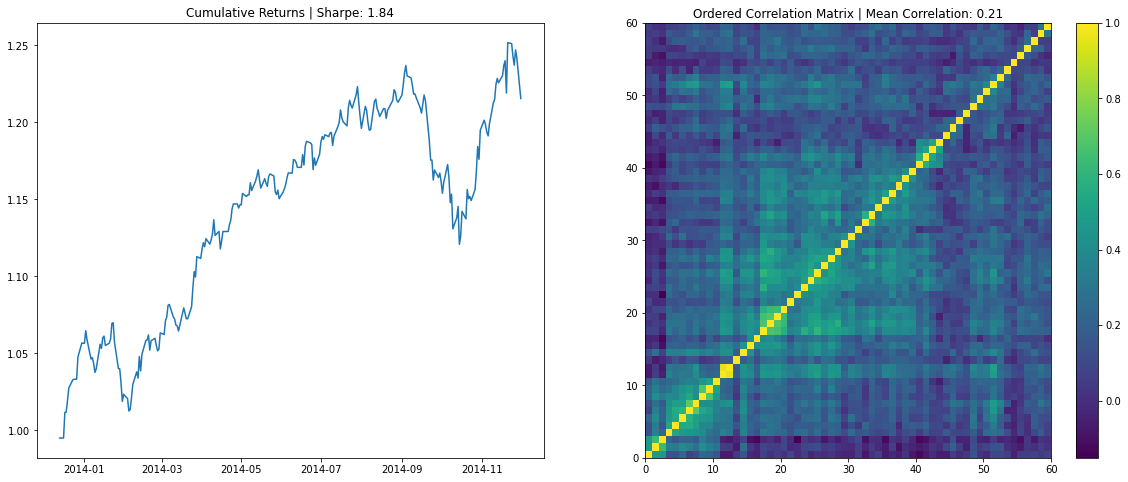

Stressed count: 6000, Rally count: 6000, Normal count: 6000


In [8]:
corr_vs_sharpe = []
stressed_mats = []
stressed_count = 0
rally_mats = []
rally_count = 0
normal_mats = []
normal_count = 0
plot_count = 0

# Create directories
for dir_name in ['stressed_mats_top60_dist', 'rally_mats_top60_dist', 'normal_mats_top60_dist']:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)  
    os.makedirs(dir_name)  

while stressed_count < 6000 or rally_count < 6000 or normal_count < 6000:
    try:
        t_idx = randint(0, len(returns) - 252)
        #print(f"Selected start index for 252-day period: {t_idx}")

        period_returns = returns.iloc[t_idx:(t_idx + 252)]
        period_market_cap = market_cap.iloc[t_idx:(t_idx + 252)]

        # Remove columns where all values are NaN
        period_returns = period_returns.dropna(axis=1, how='all')
        #print(f"Remaining shape after removing all-NaN columns: {period_returns.shape}")
        
        # Remove constant columns
        non_constant_columns = period_returns.columns[period_returns.std() > 1e-8]
        if len(non_constant_columns) < 60:
            #print("Not enough non-constant columns. Skipping this iteration.")
            continue

        period_returns = period_returns[non_constant_columns]
        period_market_cap = period_market_cap[non_constant_columns]

        # Randomly select 60 stocks, assuming there are at least 60
        if len(period_returns.columns) >= 60:
            # Select top 60 stocks based on market capitalization
            avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
            top_60_stocks = avg_market_cap.head(60).index
            period_returns = period_returns[top_60_stocks]
            
            #selected_columns = np.random.choice(period_returns.columns, 60, replace=False)
            #period_returns = period_returns[selected_columns]
        else:
            #print("Not enough columns to select 60 stocks. Skipping this iteration.")
            continue

        # Fill NaNs with 0
        period_returns = period_returns.fillna(0)

        idx = list(np.random.choice(len(period_returns.columns), dim, replace=False))

        # Calculate correlation
        corr = period_returns.corr().values
        #print(corr)
        if np.isnan(corr).any():
            #print("Correlation matrix contains NaNs. Skipping this iteration.")
            continue

        #print(f"Mean correlation: {np.nanmean(corr)}") 

        mean_return = period_returns[period_returns.columns[idx]].mean(axis=1).mean() * 252
        vol = period_returns[period_returns.columns[idx]].mean(axis=1).std() * np.sqrt(252)
        sharpe = mean_return / vol
        #print(f"Sharpe Ratio: {sharpe}")

        #dist = 1 - corr
        # Using the distance measure from Miori et al.
        # Application taken from Papenbrock et al. (2021)
        dist = np.sqrt(2 * (1 - corr))
        #print(dist)
        Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
        permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
        prows = corr[permutation, :]
        ordered_corr = prows[:, permutation]

        corr_vs_sharpe.append([corr.mean(), sharpe])

        # Define Sharpe ratio ranges for each category following Marti (2020)
        sharpe_low = -0.5  # Lower bound for "normal"
        sharpe_high = 2  # Upper bound for "normal"

        if sharpe < -0.5 and stressed_count < 6000:
            stressed_mats.append(ordered_corr)
            np.save(f'stressed_mats_top60_dist/mat_{stressed_count}.npy', ordered_corr)
            stressed_count += 1
            plot_flag = True
        elif sharpe > 2 and rally_count < 6000:
            rally_mats.append(ordered_corr)
            np.save(f'rally_mats_top60_dist/mat_{rally_count}.npy', ordered_corr)
            rally_count += 1
            plot_flag = True
        elif sharpe_low <= sharpe <= sharpe_high and normal_count < 6000:
            normal_mats.append(ordered_corr)
            np.save(f'normal_mats_top60_dist/mat_{normal_count}.npy', ordered_corr)
            normal_count += 1
            plot_flag = True
        else:
            plot_flag = False

        if plot_flag and plot_count < 10:
            # Plotting the cumulative returns and correlation matrix
            plt.figure(figsize=(20, 8))

            # Plotting cumulative returns
            plt.subplot(1, 2, 1)
            plt.plot((1 + period_returns.mean(axis=1)).cumprod())
            plt.title(f"Cumulative Returns | Sharpe: {np.round(sharpe, 2)}")

            # Plotting correlation matrix
            plt.subplot(1, 2, 2)
            plt.pcolormesh(ordered_corr)
            plt.colorbar()
            plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
            plt.show()

            plot_count += 1 

    except Exception as e:
        print(f"Error: {e}")

# Print the counts
print(f"Stressed count: {stressed_count}, Rally count: {rally_count}, Normal count: {normal_count}")

In [9]:
stressed_mats

[array([[ 1.        ,  0.77079798,  0.53474594, ..., -0.06764937,
         -0.07928057, -0.08206935],
        [ 0.77079798,  1.        ,  0.59693888, ..., -0.01892448,
         -0.03536807, -0.02678367],
        [ 0.53474594,  0.59693888,  1.        , ...,  0.03547745,
          0.10535825,  0.01475051],
        ...,
        [-0.06764937, -0.01892448,  0.03547745, ...,  1.        ,
          0.57093201,  0.45597789],
        [-0.07928057, -0.03536807,  0.10535825, ...,  0.57093201,
          1.        ,  0.39420859],
        [-0.08206935, -0.02678367,  0.01475051, ...,  0.45597789,
          0.39420859,  1.        ]]),
 array([[ 1.00000000e+00,  8.22154142e-01,  8.04301017e-01, ...,
         -1.06888988e-02,  2.68874979e-02,  7.85852696e-02],
        [ 8.22154142e-01,  1.00000000e+00,  8.70237113e-01, ...,
         -5.32485422e-02,  1.74822672e-02,  8.10669586e-02],
        [ 8.04301017e-01,  8.70237113e-01,  1.00000000e+00, ...,
         -4.00320109e-02, -9.66496926e-03,  8.54729727e-

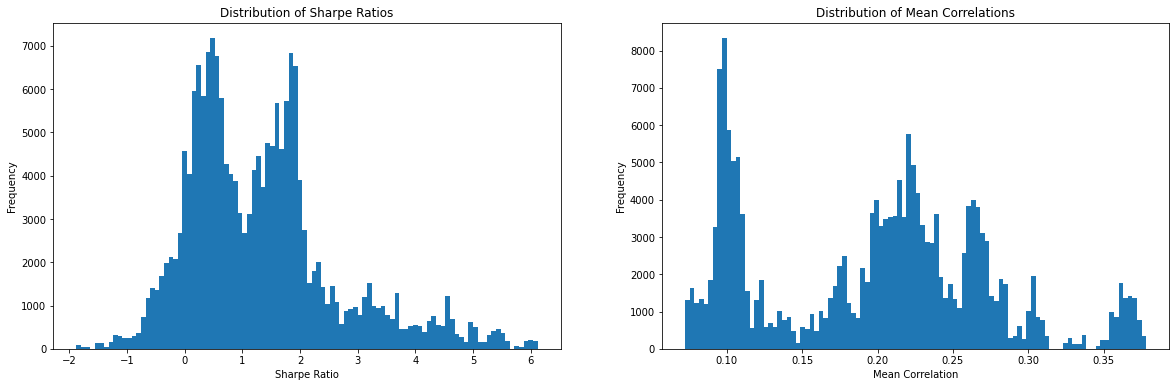

In [10]:
def plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats):
    # Extract and calculate the mean of mean correlations
    mean_correlations = [np.mean(item[0]) for item in corr_vs_sharpe if len(item) > 1]
    sharpe_ratios = [item[1] for item in corr_vs_sharpe if len(item) > 1]

    # Plot distribution of Sharpe Ratios
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.hist(sharpe_ratios, bins=100)
    plt.title('Distribution of Sharpe Ratios')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')

    # Plot distribution of Mean Correlations
    plt.subplot(1, 2, 2)
    plt.hist(mean_correlations, bins=100)
    plt.title('Distribution of Mean Correlations')
    plt.xlabel('Mean Correlation')
    plt.ylabel('Frequency')
    plt.show()

# Usage
plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats)

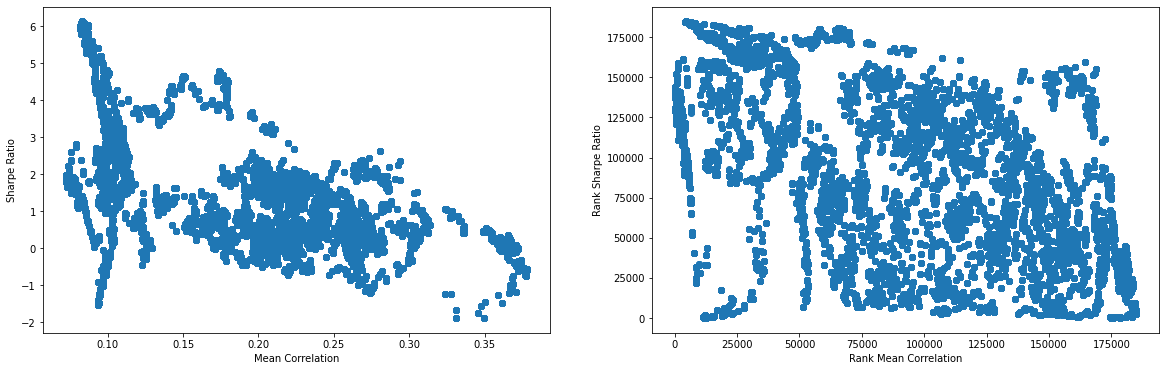

In [11]:
# Convert corr_vs_sharpe to a NumPy array if it's not already
corr_vs_sharpe_array = np.array(corr_vs_sharpe)

plt.figure(figsize=(20, 6))

# First plot: Scatter plot of mean correlation vs. sharpe
plt.subplot(1, 2, 1)
plt.scatter(corr_vs_sharpe_array[:, 0], corr_vs_sharpe_array[:, 1])
plt.xlabel('Mean Correlation')
plt.ylabel('Sharpe Ratio')

# Second plot: Scatter plot of rank of mean correlation vs. rank of sharpe
plt.subplot(1, 2, 2)
plt.scatter(rankdata(corr_vs_sharpe_array[:, 0]), rankdata(corr_vs_sharpe_array[:, 1]))
plt.xlabel('Rank Mean Correlation')
plt.ylabel('Rank Sharpe Ratio')

plt.show()


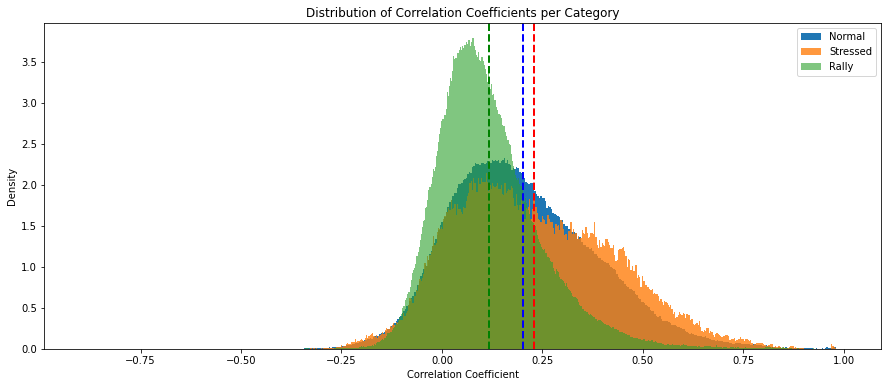

In [12]:
def plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b):
    # Extract correlation coefficients for each category
    stressed_corr_coeffs = [mat[tri_a, tri_b] for mat in stressed_mats]  
    rally_corr_coeffs = [mat[tri_a, tri_b] for mat in rally_mats]        
    normal_corr_coeffs = [mat[tri_a, tri_b] for mat in normal_mats]      

    # Flatten the lists
    stressed_corr_coeffs = [item for sublist in stressed_corr_coeffs for item in sublist]
    rally_corr_coeffs = [item for sublist in rally_corr_coeffs for item in sublist]
    normal_corr_coeffs = [item for sublist in normal_corr_coeffs for item in sublist]

    # Number of bins
    nbins = 500

    # Plotting distribution of correlation coefficients per category
    plt.figure(figsize=(15, 6))

    plt.hist(normal_corr_coeffs, bins=nbins, alpha=1, label='Normal', density=True, log=False)
    plt.axvline(x=np.mean(normal_corr_coeffs), color='b', linestyle='dashed', linewidth=2)

    plt.hist(stressed_corr_coeffs, bins=nbins, alpha=0.8, label='Stressed', density=True, log=False)
    plt.axvline(x=np.mean(stressed_corr_coeffs), color='r', linestyle='dashed', linewidth=2)

    plt.hist(rally_corr_coeffs, bins=nbins, alpha=0.6, label='Rally', density=True, log=False)
    plt.axvline(x=np.mean(rally_corr_coeffs), color='g', linestyle='dashed', linewidth=2)

    plt.legend()
    plt.title('Distribution of Correlation Coefficients per Category')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Density')
    
    plt.show()

# Usage example (make sure tri_a and tri_b are correctly defined)
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)
plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b)

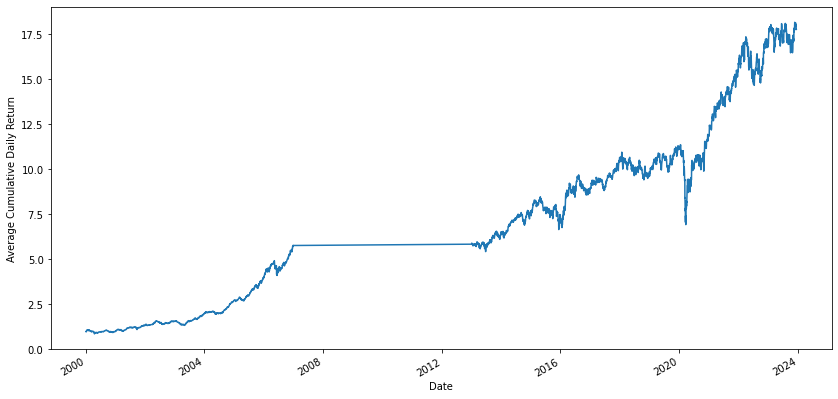

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'returns' and 'market_cap' are pandas DataFrames
# and the index for 'returns' is the datetime of the returns
# Ensure that the 'market_cap' DataFrame is aligned with 'returns' and has the same column names and index.

# Initialize an empty list to store average returns
average_daily_returns = []

# Loop through each day in the returns DataFrame
for date in returns.index:
    # Select the market cap for the current day
    current_market_cap = market_cap.loc[date]
    
    # Find the top 60 stocks by market cap for the current day
    top_60_stocks = current_market_cap.nlargest(60).index
    
    # Select the returns for the top 60 stocks
    current_returns = returns.loc[date, top_60_stocks]
    
    # Calculate the average return for the current day for the top 60 stocks
    average_return = current_returns.mean()
    
    # Store the average return
    average_daily_returns.append(average_return)

# Convert the average daily returns list into a pandas Series
average_daily_returns_series = pd.Series(average_daily_returns, index=returns.index)

# cumrets
cumulative_returns = (1 + average_daily_returns_series).cumprod()

# Plot the time series of average daily returns
plt.figure(figsize=(14, 7))
cumulative_returns.plot()
plt.xlabel('Date')
plt.ylabel('Average Cumulative Daily Return')
plt.savefig('cumretstop60.png', bbox_inches='tight')
plt.show()



In [16]:
test_returns

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2007-01-01,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,...,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000
2007-01-02,0.015188,0.000000,0.000000,0.011867,NaN,0.000000,0.013012,NaN,NaN,0.001133,...,NaN,NaN,0.010672,0.001873,0.000000,NaN,-0.027368,NaN,-0.000685,-0.003886
2007-01-03,-0.007874,0.000000,-0.008499,-0.000869,NaN,-0.005128,-0.038389,NaN,NaN,-0.021003,...,NaN,NaN,-0.003496,-0.007788,-0.000482,NaN,0.000000,NaN,-0.006169,-0.012828
2007-01-04,-0.024921,-0.016130,0.000000,-0.014493,NaN,-0.001031,-0.016419,NaN,NaN,-0.036949,...,NaN,NaN,0.021052,-0.004710,-0.022824,NaN,0.000000,NaN,-0.006483,-0.006213
2007-01-05,0.006837,-0.009843,-0.014286,-0.007353,NaN,0.000000,0.002869,NaN,NaN,-0.002475,...,NaN,NaN,0.003436,-0.012618,0.022857,NaN,0.001082,NaN,-0.014300,0.000567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-18,-0.015360,0.007875,0.007223,-0.007670,NaN,-0.010187,-0.011457,NaN,-0.012969,-0.010060,...,NaN,NaN,-0.024949,-0.004878,-0.024997,NaN,0.001251,-0.024390,-0.031496,-0.016530
2012-05-21,0.009933,0.000000,0.002390,0.001189,NaN,0.005146,-0.005739,NaN,0.001266,-0.006362,...,NaN,NaN,-0.003356,-0.001225,0.008544,NaN,0.013741,0.031000,0.009756,0.001244
2012-05-22,0.006337,-0.070318,0.003180,-0.002375,NaN,-0.010239,0.024925,NaN,0.004901,0.000266,...,NaN,NaN,0.007155,0.006135,0.000000,NaN,-0.014171,0.013579,0.022544,0.010363


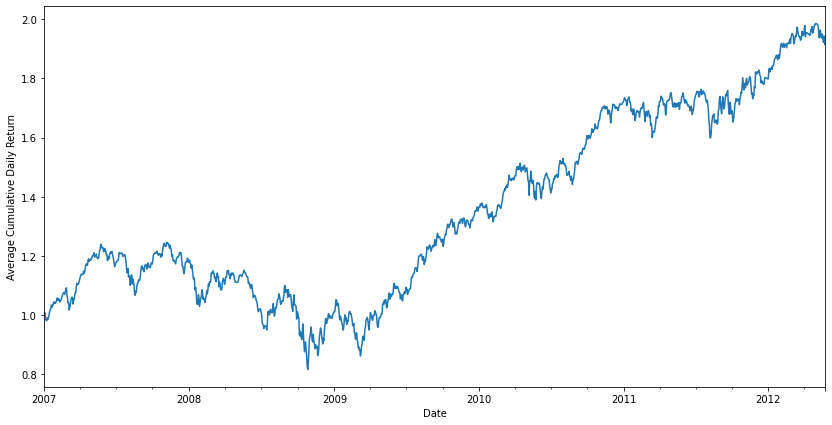

In [17]:
# Initialize an empty list to store average returns
average_daily_returns = []

# Loop through each day in the returns DataFrame
for date in test_returns.index:
    # Select the market cap for the current day
    current_market_cap = test_market_cap.loc[date]
    
    # Find the top 60 stocks by market cap for the current day
    top_60_stocks = current_market_cap.nlargest(60).index
    
    # Select the returns for the top 60 stocks
    current_returns = test_returns.loc[date, top_60_stocks]
    
    # Calculate the average return for the current day for the top 60 stocks
    average_return = current_returns.mean()
    
    # Store the average return
    average_daily_returns.append(average_return)

# Convert the average daily returns list into a pandas Series
average_daily_returns_series = pd.Series(average_daily_returns, index=test_returns.index)

# cumrets
cumulative_returns = (1 + average_daily_returns_series).cumprod()

# Plot the time series of average daily returns
plt.figure(figsize=(14, 7))
cumulative_returns.plot()
plt.xlabel('Date')
plt.ylabel('Average Cumulative Daily Return')
plt.savefig('cumretstop60backtest.png', bbox_inches='tight')
plt.show()

In [18]:
# Convert the average daily returns list into a pandas Series
average_daily_returns_series = pd.Series(average_daily_returns, index=returns.index)

# Plot the time series of average daily returns
plt.figure(figsize=(14, 7))
average_daily_returns_series.plot()
plt.xlabel('Date')
plt.ylabel('Average Daily Return')
plt.savefig('retstop60.png', bbox_inches='tight')
plt.show()

ValueError: Length of values (1409) does not match length of index (4680)

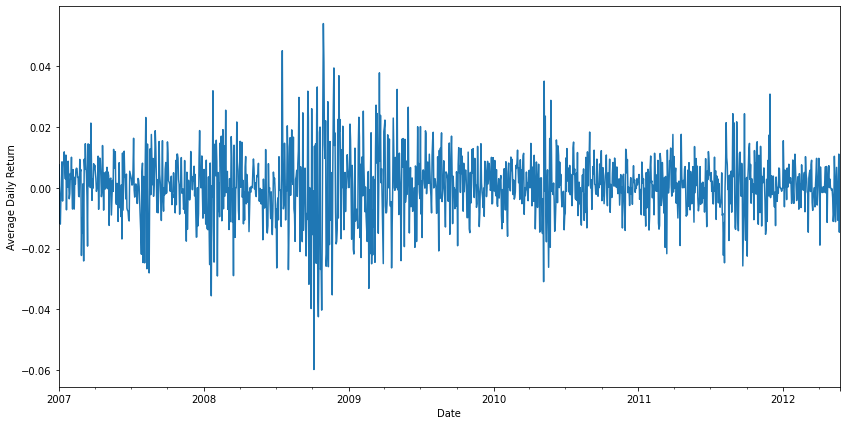

In [19]:
# Convert the average daily returns list into a pandas Series
average_daily_returns_series = pd.Series(average_daily_returns, index=test_returns.index)

# Plot the time series of average daily returns
plt.figure(figsize=(14, 7))
average_daily_returns_series.plot()
plt.xlabel('Date')
plt.ylabel('Average Daily Return')
plt.savefig('retstop60backtest.png', bbox_inches='tight')
plt.show()

In [15]:
corr_vs_sharpe_df = pd.DataFrame(columns=['Correlation', 'Sharpe', 'Label'])
period_rets = []

for t_idx in range(0, len(test_returns) - 252):
    start_date = test_returns.index[t_idx+252] 
    period_returns = test_returns.iloc[t_idx:(t_idx + 252)].fillna(0)
    period_market_cap = test_market_cap.iloc[t_idx:(t_idx + 252)].fillna(0)

    # Randomly select 60 stocks, assuming there are at least 60
    if len(period_returns.columns) >= 60:
        # Select top 60 stocks based on market capitalization
        avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
        top_60_stocks = avg_market_cap.head(60).index
        period_returns = period_returns[top_60_stocks]
    else:
        #print("Not enough columns to select 60 stocks. Skipping this iteration.")
        continue

    # Fill NaNs with 0
    period_returns = period_returns.fillna(0)
    
    period_rets.append(period_returns)

    # Calculate correlation
    corr = period_returns.corr().fillna(0).values
    
    # Sharpe values
    mean_return = period_returns.mean(axis=1).mean() * 252
    vol = period_returns.mean(axis=1).std() * np.sqrt(252)
    sharpe = mean_return / vol
    
    # Order corr
    dist = np.sqrt(2 * (1 - corr))
    #print(dist)
    Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
    prows = corr[permutation, :]
    ordered_corr = prows[:, permutation]
    
    # Define Sharpe ratio ranges for each category following Marti (2020)
    sharpe_low = -0.5  # Lower bound for "normal"
    sharpe_high = 2  # Upper bound for "normal"
    
    # Define Sharpe ratio ranges for each category
    sharpe_low = -0.5  # "normal" lower bound
    sharpe_high = 2    # "normal" upper bound
    label = 'normal' if sharpe_low <= sharpe <= sharpe_high else 'rally' if sharpe > sharpe_high else 'stressed'

    # Append to DataFrame
    corr_vs_sharpe_df = corr_vs_sharpe_df.append({'Correlation': ordered_corr, 'Sharpe': sharpe, 'Label': label}, ignore_index=True)

    

In [16]:
# Convert labels from categorical to numerical
label_mapping = {'stressed': 0, 'normal': 1, 'rally': 2}
corr_vs_sharpe_df['Label'] = corr_vs_sharpe_df['Label'].map(label_mapping)

# Extract matrices and labels
test_matrices = list(corr_vs_sharpe_df['Correlation'])
test_labels = list(corr_vs_sharpe_df['Label'])

In [25]:
import scipy.io
import numpy as np

# Load the MATLAB file
mat = scipy.io.loadmat('/Users/alexa/Documents/MATLAB/U-SPDNet/data/afew/final_predictions.mat')  # Update the path after uploading

# Extract predictions
predictions = mat['all_predictions']

# Select the first row which contains the probabilities for the class with the highest probability
highest_probabilities = predictions[0, :]-1

# Now, highest_probabilities is an array that can be used for further analysis
highest_probabilities

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

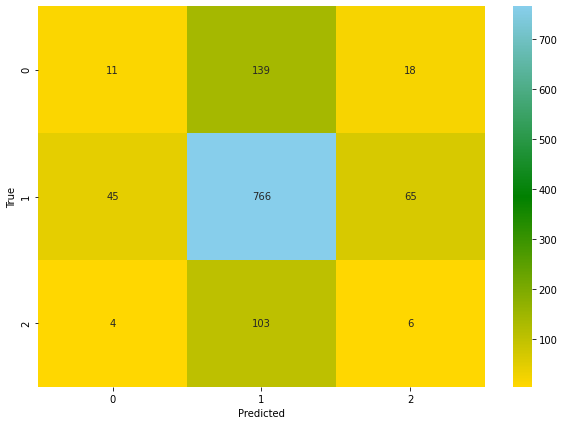

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(test_labels, highest_probabilities[:1157])
# [:1157]
custom_colors = ["#ffd700", "#008000", "#87CEEB"]  # Gold, Green, Bright Sky Blue
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

sns.heatmap(cm, annot=True, fmt="d", cmap=custom_cmap)  # Use the custom colormap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('top60_uspdnet_confusion_matrix.png', bbox_inches='tight')
plt.show()

In [9]:
# Directory names corresponding to labels
label_dirs = {0: 'stressed', 1: 'normal', 2: 'rally'}

# Base directory where you want to save the directories
base_dir = os.getcwd()  # Update this path as necessary

# Create directories if they don't exist
for label in label_dirs.values():
    dir_path = os.path.join(base_dir, label)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Save matrices in their respective directories
for i, matrix in enumerate(test_matrices):
    label = test_labels[i]
    dir_name = label_dirs[label]
    file_path = os.path.join(base_dir, dir_name, f'matrix_{i}.npy')
    np.save(file_path, matrix)

print("Matrices have been saved in their respective directories.")


Matrices have been saved in their respective directories.


In [10]:
# Define the relative paths for each category
data_paths = {
    'stressed': 'stressed_mats_top60_dist',
    'normal': 'normal_mats_top60_dist',
    'rally': 'rally_mats_top60_dist'
}

# Assign labels to each category
labels = {'stressed': 0, 'normal': 1, 'rally': 2}

# Initialize lists for storing data and labels
all_matrices = []
all_labels = []

for category, rel_path in data_paths.items():
    full_path = os.path.join(os.getcwd(), rel_path)
    category_count = 0
    for filename in os.listdir(full_path):
        if filename.endswith('.npy'):
            matrix = np.load(os.path.join(full_path, filename))
            all_matrices.append(matrix)
            all_labels.append(labels[category])
            category_count += 1
    print(f'Category: {category}, Count: {category_count}')

# Combine matrices and labels into a single list of tuples and shuffle
combined_data = list(zip(all_matrices, all_labels))
random.Random(0).shuffle(combined_data)

# Unzip the shuffled data
shuffled_matrices, shuffled_labels = zip(*combined_data)

print(f'Total number of matrices: {len(shuffled_matrices)}')

Category: stressed, Count: 6000
Category: normal, Count: 6000
Category: rally, Count: 6000
Total number of matrices: 18000


In [11]:
class DatasetCorrMats(data.Dataset):
    def __init__(self, matrices, labels):
        self.matrices = matrices
        self.labels = labels

    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        x = th.from_numpy(self.matrices[idx]).double()
        x = x[None, :, :]  # Add channel dimension
        
        y = th.tensor(self.labels[idx], dtype=th.long)
        
        return x, y

In [12]:
class CorrMatsNet(nn.Module):
    def __init__(self, bn=False):
        super(__class__, self).__init__()
        dim = 60
        dim1 = 20
        classes = 3
        self._bn = bn
        self.bimap1 = spdnet.BiMap(1, 1, dim, dim1)
        if bn:
            self.batchnorm1 = spdnet.BatchNormSPD(dim1)
        self.logeig = spdnet.LogEig()
        self.linear = nn.Linear(dim1**2, classes).double()
    def forward(self, x):
        x = self.bimap1(x)
        if self._bn:
            x = self.batchnorm1(x)
        x = self.logeig(x)
        x_vec = x.view(x.shape[0], -1)
        y = self.linear(x_vec)
        return y

In [13]:
def train_model(train_generator, test_generator, use_rbn=True,
                batch_size=30, lr=1e-2, threshold_reeig = 1e-4, epochs=30,
                n=60, C=3):

  model = CorrMatsNet(bn=use_rbn)

  loss_fn = nn.CrossEntropyLoss()
  opti = MixOptimizer(model.parameters(),lr=lr)

  #initial validation accuracy
  loss_val, acc_val = [], []
  y_true, y_pred = [], []
  model.eval()
  for local_batch, local_labels in test_generator:
      out = model(local_batch)
      l = loss_fn(out, local_labels)
      predicted_labels=out.argmax(1)
      y_true.extend(list(local_labels.cpu().numpy()))
      y_pred.extend(list(predicted_labels.cpu().numpy()))
      acc, loss = ((predicted_labels==local_labels)
                  .cpu()
                  .numpy()
                  .sum()/out.shape[0],
                  l.cpu().data.numpy())
      loss_val.append(loss)
      acc_val.append(acc)
  acc_val = np.asarray(acc_val).mean()
  loss_val = np.asarray(loss_val).mean()
  print('Initial validation accuracy: ' + str(round(100 * acc_val, 2)) + '%')
  spdnet_acc = []
  spdnet_acc.append(acc_val)

  #training loop
  for epoch in range(epochs):

      # train one epoch
      loss_train, acc_train = [], []
      model.train()
      for local_batch, local_labels in train_generator:
          opti.zero_grad()
          out = model(local_batch)
          l = loss_fn(out, local_labels)
          acc, loss = ((out.argmax(1) == local_labels)
                      .cpu()
                      .numpy()
                      .sum()/out.shape[0],
                      l.cpu().data.numpy())
          loss_train.append(loss)
          acc_train.append(acc)
          l.backward()
          opti.step()
      acc_train = np.asarray(acc_train).mean()
      loss_train = np.asarray(loss_train).mean()

      # validation
      acc_val_list = []
      loss_val_list = []
      y_true, y_pred = [], []
      model.eval()
      for local_batch, local_labels in test_generator:
          out = model(local_batch)
          l = loss_fn(out, local_labels)
          predicted_labels = out.argmax(1)
          y_true.extend(list(local_labels.cpu().numpy()))
          y_pred.extend(list(predicted_labels.cpu().numpy()))
          acc, loss = ((predicted_labels == local_labels)
                      .cpu()
                      .numpy()
                      .sum()/out
                      .shape[0], 
                      l.cpu().data.numpy())
          acc_val_list.append(acc)
          loss_val_list.append(loss)
      acc_val = np.asarray(acc_val_list).mean()
      loss_val = np.asarray(loss_val_list).mean()

      if (epoch + 1) % 1 == 0:
        print('Val acc: ' + str(round(100 * acc_val, 2)) + '% at epoch ' +
              str(epoch + 1) + '/' + str(epochs))

      spdnet_acc.append(acc_val)

  return spdnet_acc, model, y_true, y_pred

In [15]:
acc_results = []
std_results = []
batch_size = 32
# train_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200]
for use_rbn in [False]:
    print(f'RBN={use_rbn}')

    # Create dataset instances
    train_set = DatasetCorrMats(shuffled_matrices, shuffled_labels)
    test_set = DatasetCorrMats(test_matrices, test_labels)

    # DataLoader instances
    train_generator = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_generator = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    test_accuracy, model, y_true, y_pred = train_model(train_generator, test_generator, use_rbn=use_rbn)

    acc_results.append(test_accuracy)
    
acc_results = np.array(acc_results)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

RBN=False
Initial validation accuracy: 47.97%
Val acc: 19.0% at epoch 1/30
Val acc: 43.63% at epoch 2/30
Val acc: 47.01% at epoch 3/30
Val acc: 44.98% at epoch 4/30
Val acc: 46.54% at epoch 5/30
Val acc: 54.56% at epoch 6/30
Val acc: 56.5% at epoch 7/30
Val acc: 55.49% at epoch 8/30
Val acc: 61.57% at epoch 9/30
Val acc: 61.57% at epoch 10/30
Val acc: 59.71% at epoch 11/30
Val acc: 65.46% at epoch 12/30
Val acc: 64.36% at epoch 13/30
Val acc: 64.7% at epoch 14/30
Val acc: 63.18% at epoch 15/30
Val acc: 66.05% at epoch 16/30
Val acc: 67.15% at epoch 17/30
Val acc: 68.24% at epoch 18/30
Val acc: 69.68% at epoch 19/30
Val acc: 68.5% at epoch 20/30
Val acc: 70.1% at epoch 21/30
Val acc: 69.0% at epoch 22/30
Val acc: 67.65% at epoch 23/30
Val acc: 68.92% at epoch 24/30
Val acc: 69.34% at epoch 25/30
Val acc: 69.09% at epoch 26/30
Val acc: 68.75% at epoch 27/30
Val acc: 69.26% at epoch 28/30
Val acc: 68.58% at epoch 29/30
Val acc: 69.43% at epoch 30/30


In [16]:
# Specify the directory and file name
directory = '/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched'
file_name = 'y_pred.npy'  # Use .npy extension for binary format, or .txt for text format

# Create directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Full path for the file
file_path = os.path.join(directory, file_name)

# Save the array
np.save(file_path, y_pred)  # For binary format, easily loadable with numpy.load
# np.savetxt(file_path, y_pred, fmt='%d')  # Uncomment for text format

print(f"Array saved to {file_path}")

Array saved to /Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched/y_pred.npy


In [17]:
# Specify the path to your saved file
file_path = '/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched/y_pred.npy'

# Load the array
y_pred = np.load(file_path)

# y_pred_loaded is now an array that you can use in further computations
print(y_pred)

[2 2 2 ... 1 1 1]


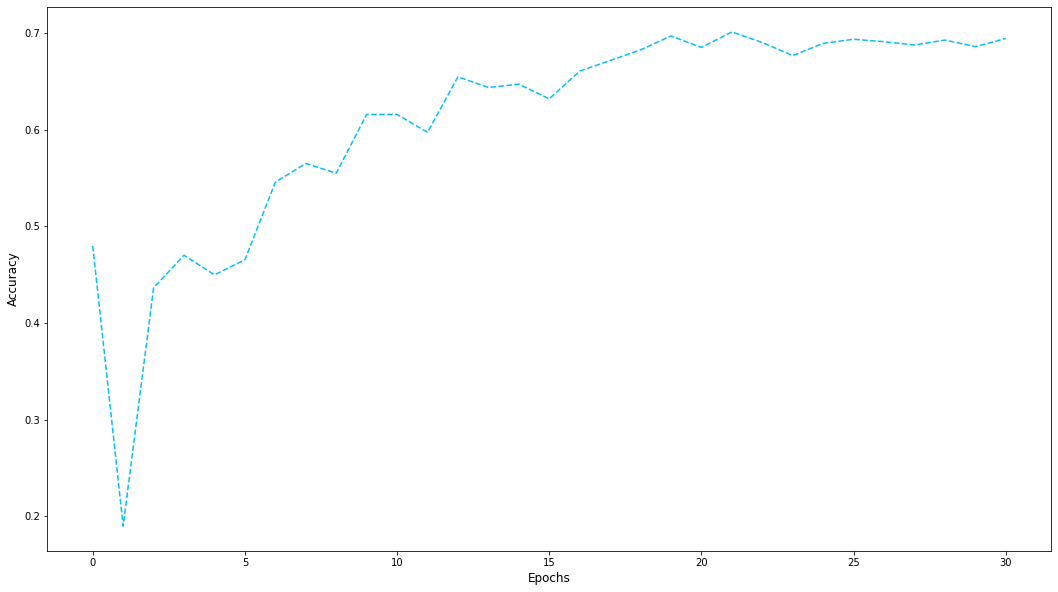

In [18]:
plt.figure(figsize=(18, 10))
acc_results = acc_results.flatten()
plt.plot(acc_results, '--',
           color='deepskyblue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.savefig('accuracy_plot_top60_backtest.png', bbox_inches='tight')
plt.show()

In [ ]:
acc_results

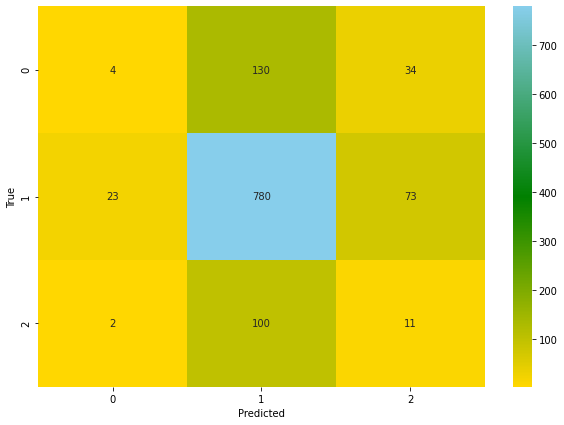

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
custom_colors = ["#ffd700", "#008000", "#87CEEB"]  # Gold, Green, Bright Sky Blue
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=custom_cmap)  # Use the custom colormap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('top60_confusion_matrix.png', bbox_inches='tight')
plt.show()

In [ ]:
y_pred

In [66]:
# Assuming average_daily_returns_series is already defined and includes the index as dates

# Starting index for y_pred
start_index = 252

# Create a subset of the average_daily_returns_series starting from the 252nd day
sub_series = average_daily_returns_series.iloc[start_index:]

# Define colors for each regime
colors = {0: 'deepskyblue', 1: 'green', 2: 'gold'}

# Plot the time series of average daily returns
plt.figure(figsize=(14, 7))

# After plotting the backgrounds, plot the series on top
sub_series.plot()

# Plot color-coded backgrounds
prev_label = y_pred[0]
start_date = sub_series.index[0]
for i, (label, date) in enumerate(zip(y_pred, sub_series.index)):
    if label != prev_label or i == len(y_pred) - 1:
        end_date = date
        plt.fill_betweenx(y=[sub_series.min(), sub_series.max()], x1=start_date, x2=end_date, color=colors[prev_label], alpha=0.3)
        start_date = date
        prev_label = label

# Add labels and save the figure
plt.xlabel('Date')
plt.ylabel('Average Daily Return')
plt.savefig('retstop60backtest_with_colored_backgrounds.png', bbox_inches='tight')
plt.show()


NameError: name 'average_daily_returns_series' is not defined

## Portfolio construction: 
- do the correlation matrices calculated for each regime need to be from the data outside the test dataset (so before 2007 and after 2013) or can they be from the test dataset alone?
- should the portfolio be rebalanced monthly? which label should be used? the label on the day? or daily using the label on the day?

### NB: rerun loading data snippet before continuing from this point to ensure correct data purging and embargoing for the backtesting

In [ ]:
df = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 0)
market_cap = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 1)

df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
market_cap['Dates'] = pd.to_datetime(market_cap['Dates'], infer_datetime_format=True)

df.index = df['Dates']
del df['Dates']
df = df.sort_index()

market_cap.index = market_cap['Dates']
del market_cap['Dates']
market_cap = market_cap.sort_index()

returns = df.pct_change(periods=1)
returns.tail()

In [34]:
returns

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,-0.023339,-0.079004,-0.044776,0.000000,NaN,NaN,-0.001506,NaN,NaN,-0.050429,...,NaN,NaN,NaN,-0.014706,-0.032219,NaN,NaN,NaN,-0.040000,-0.039915
2000-01-06,-0.009191,0.000000,0.003125,0.035298,NaN,NaN,0.035679,NaN,NaN,-0.012429,...,NaN,NaN,NaN,-0.007463,-0.033375,NaN,NaN,NaN,0.000000,-0.046758
2000-01-07,0.035250,0.000000,0.012461,0.106061,NaN,NaN,0.028627,NaN,NaN,0.003432,...,NaN,NaN,NaN,0.000000,0.034527,NaN,NaN,NaN,0.020833,0.035429
2000-01-10,0.057348,0.095247,0.176923,0.000000,NaN,NaN,0.012736,NaN,NaN,0.003421,...,NaN,NaN,NaN,0.004511,0.066667,NaN,NaN,NaN,0.010204,0.078964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,-0.023719,0.000000,0.000000,-0.040570,-0.061489,-0.010539,0.001028,0.036961,-0.034783,0.026879,...,0.020618,0.000705,-0.052000,-0.025654,0.019185,0.000000,-0.014184,-0.015575,0.000077,-0.021780
2023-12-08,-0.063146,0.000000,-0.010000,-0.028571,0.029310,0.009941,-0.133194,-0.049505,-0.008108,-0.003209,...,0.016547,0.014085,-0.008439,0.015449,-0.005490,0.000000,-0.012950,0.010513,0.004461,0.013804
2023-12-11,-0.002443,0.004800,-0.055556,0.027353,0.005025,0.013359,-0.041542,-0.004167,0.023978,0.019262,...,-0.005290,0.006944,-0.025532,-0.018918,0.000000,0.009730,0.026239,0.003030,0.008347,0.001757


In [72]:
import pandas as pd

# Assuming `returns` and `market_cap` are your DataFrames with stocks as columns and dates as rows

# Initialize an empty DataFrame for storing the filtered returns of the top 60 stocks
top_60_returns = pd.DataFrame()

sharpe_classifications = []

# Calculate the number of windows to iterate over
num_windows = len(returns) - 251  # for a 252-day window

# Loop through each window
for i in range(num_windows):
    # Define the current window's start and end dates
    start_idx = i
    end_idx = i + 251  # 252-day window
    
    # Extract the current window's data
    period_market_cap = market_cap.iloc[start_idx:end_idx + 1]
    period_returns = returns.iloc[start_idx:end_idx + 1]
    
    # Determine the top 60 stocks based on average market capitalization within the window, if possible
    if len(period_returns.columns) >= 60:
        avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
        top_60_stocks = avg_market_cap.head(60).index
        period_returns = period_returns[top_60_stocks].fillna(0)
        
    # Calculate annualized mean return and volatility for the period
    mean_return = period_returns.mean(axis=1).mean() * 252
    vol = period_returns.std(axis=1).mean() * np.sqrt(252)

    # Compute Sharpe Ratio, adjusting for the risk-free rate
    sharpe = (mean_return) / vol

    # Classify Sharpe ratio
    if sharpe < -0.5:
        sharpe_class = 0
    elif sharpe <= 2:
        sharpe_class = 1
    else:
        sharpe_class = 2

    sharpe_classifications.append(sharpe_class)
    
    # Append the returns of the top 60 stocks to the DataFrame
    # Note: We only want the last day's returns in each window
    last_day_returns = period_returns.iloc[-1]

    top_60_returns = top_60_returns.append(last_day_returns)

# Set the correct index for the top_60_returns DataFrame
top_60_returns.index = returns.index[251:]  # Adjusting to match the dates of the analysis windows
sharpe_classifications_series = pd.DataFrame(sharpe_classifications, index=returns.index[251:])
# `top_60_returns` now contains the daily returns of the top 60 stocks by average market cap for each 252-day window, starting from the first window


In [22]:
top_60_returns

,AGL SJ Equity,CFR SJ Equity,AMS SJ Equity,MTN SJ Equity,FSR SJ Equity,SBK SJ Equity,NED SJ Equity,SOL SJ Equity,ANG SJ Equity,REM SJ Equity,...,OMU SJ Equity,MCG SJ Equity,PRX SJ Equity,NY1 SJ Equity,N91 SJ Equity,MKR SJ Equity,TCP SJ Equity,SRE SJ Equity,TGA SJ Equity,TXT SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.025096,-0.013528,0.000608,-0.025751,0.035977,-0.003322,-0.008168,0.002110,0.002811,0.028632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,0.000000,-0.002110,0.015198,-0.017621,0.000000,-0.013333,-0.005882,-0.014737,0.060747,0.014436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.009901,0.014800,0.035928,0.076233,0.035930,0.035472,0.040236,0.000000,0.013216,0.065039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,0.001028,-0.005012,0.026879,-0.015722,-0.023529,-0.022287,-0.030589,-0.017540,-0.033383,-0.021361,...,-0.017500,-0.016242,-0.007806,-0.004693,-0.005702,NaN,NaN,NaN,NaN,0.000000
2023-12-08,-0.133194,0.030412,-0.003209,0.005548,0.001506,-0.001960,-0.011470,-0.031134,-0.031073,0.035729,...,-0.003393,0.004634,0.004898,0.022581,0.017203,NaN,NaN,NaN,NaN,0.000000
2023-12-11,-0.041542,0.022139,0.019262,0.023114,0.004060,0.008526,-0.004161,-0.013876,-0.014691,0.014161,...,0.010213,0.015713,0.011456,0.009706,0.014706,NaN,NaN,NaN,NaN,0.009730


In [23]:
sharpe_classifications_series


,0
Dates,
2000-12-20,1
2000-12-21,1
2000-12-22,1
2000-12-25,1
2000-12-26,1
...,...
2023-12-07,1
2023-12-08,1
2023-12-11,1


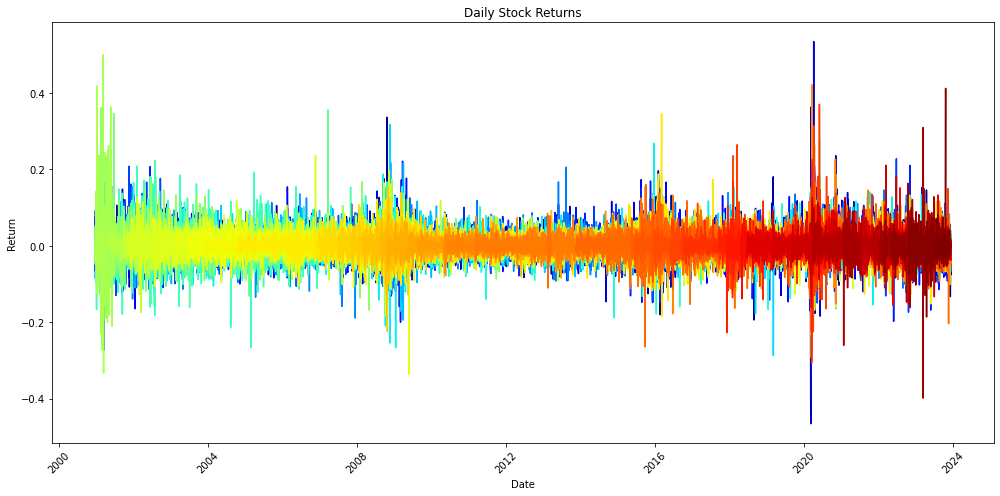

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Generate a color palette with enough colors or cycle through existing colors
num_stocks = len(top_60_returns.columns)
colors = plt.cm.jet(np.linspace(0, 1, num_stocks))

for i, column in enumerate(top_60_returns.columns):
    # Use modulo operator to cycle through colors if there are more stocks than colors
    plt.plot(top_60_returns.index, top_60_returns[column], color=colors[i % num_stocks], label=column)

plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Daily Stock Returns')
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Optional: Create a custom legend if the direct inclusion makes the plot cluttered
# plt.legend(loc='upper right', fontsize='small', ncol=4)

plt.tight_layout()
plt.show()


In [73]:
dates_to_remove = [pd.to_datetime('2006-12-31'), pd.to_datetime('2013-01-01')]

# Remove the dates to remove from both dataframes
top_60_returns = top_60_returns[~top_60_returns.index.isin(dates_to_remove)]
market_cap = market_cap[~market_cap.index.isin(dates_to_remove)]
sharpe_classifications_series = sharpe_classifications_series[~sharpe_classifications_series.index.isin(dates_to_remove)]

# Define the start and end of the test period
test_period_start = pd.to_datetime('2007-01-01')
test_period_end = pd.to_datetime('2012-12-31')

# Split data into test and train datasets based on the period, for both df and market_cap
test_df = top_60_returns.loc[test_period_start:test_period_end]
train_df = pd.concat([top_60_returns.loc[:test_period_start - pd.Timedelta(days=1)], top_60_returns.loc[test_period_end + pd.Timedelta(days=1):]])
train_sharpe = pd.concat([sharpe_classifications_series.loc[:test_period_start - pd.Timedelta(days=1)], sharpe_classifications_series.loc[test_period_end + pd.Timedelta(days=1):]])

# Calculate the cutoff index to retain only the first 90% of the test dataset
cut_off_index_df = int(len(test_df) * 0.9)
cut_off_index_market_cap = int(len(test_market_cap) * 0.9)

# Apply the cutoff to both test datasets
test_df = test_df.iloc[:cut_off_index_df]

In [78]:
test_df

,AGL SJ Equity,CFR SJ Equity,AMS SJ Equity,MTN SJ Equity,FSR SJ Equity,SBK SJ Equity,NED SJ Equity,SOL SJ Equity,ANG SJ Equity,REM SJ Equity,...,OMU SJ Equity,MCG SJ Equity,PRX SJ Equity,NY1 SJ Equity,N91 SJ Equity,MKR SJ Equity,TCP SJ Equity,SRE SJ Equity,TGA SJ Equity,TXT SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2007-12-19,-0.030278,-0.008680,0.005348,-0.009473,0.000000,-0.029127,-0.030604,0.008709,-0.031494,-0.006504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-12-20,-0.008653,0.035025,0.053191,0.043659,0.024393,0.000000,0.033860,0.027002,0.010638,0.007671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-12-21,0.038654,0.015184,0.060606,0.055697,-0.007145,0.020000,0.045118,0.063895,0.030035,0.012537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-12-24,0.016783,0.021368,0.000000,0.010567,-0.004796,0.004902,-0.011687,0.004023,0.025310,-0.032581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-18,-0.011457,-0.013693,-0.010060,-0.014504,-0.038462,-0.016080,-0.032164,-0.015043,0.062937,-0.000763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21,-0.005739,0.021529,-0.006362,0.001585,-0.006000,-0.001767,-0.003927,-0.009850,-0.001504,-0.009924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-22,0.024925,0.009454,0.000266,0.003542,0.018109,0.009646,0.034031,0.024025,0.026095,0.020741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Starting index for y_pred
start_index = 252

# Create a subset of the average_daily_returns_series starting from the 252nd day
test_df = test_df.iloc[start_index:]

In [76]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Calculate expected returns and covariance matrix from train_df
mean_returns = train_df.mean()
cov_matrix = train_df.cov()

def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = [1./num_assets] * num_assets
    
    # Adjust the portfolio_variance function to accept the covariance matrix as an argument
    def portfolio_variance(weights, cov_matrix):
        return weights.T @ cov_matrix @ weights
    
    # Use a lambda function to pass 'cov_matrix' to 'portfolio_variance'
    result = minimize(lambda weights: portfolio_variance(weights, cov_matrix), initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x


# Daily rebalancing and calculating portfolio returns
daily_portfolio_returns = []
for _, returns_today in test_df.iterrows():
    weights = optimize_portfolio(mean_returns, cov_matrix)
    portfolio_return = np.dot(returns_today, weights)
    daily_portfolio_returns.append(portfolio_return)

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = np.cumprod(1 + np.array(daily_portfolio_returns))


In [77]:
cumulative_portfolio_returns

array([nan, nan, nan, ..., nan, nan, nan])

In [36]:
y_pred

array([2, 2, 2, ..., 1, 1, 1])

In [51]:
import pandas as pd
import numpy as np

# Assuming y_pred is a list or a pandas Series, ensure it's a numpy array
train_sharpe = np.array(train_sharpe)

# Initialize an empty DataFrame to store selected returns
selected_returns = pd.DataFrame(columns=train_df.columns)


In [55]:
train_sharpe = train_sharpe.flatten()

In [56]:
# Categories as indicated in y_pred
categories = np.unique(train_sharpe)

# Dictionary to hold DataFrames for each category
category_returns = {category: pd.DataFrame(columns=train_df.columns) for category in categories}

for i, category in enumerate(train_sharpe):
    # Select the row from test_returns corresponding to the current category
    row = train_df.iloc[[i]]
    
    # Append this row to the corresponding category DataFrame
    category_returns[category] = category_returns[category].append(row)


In [57]:
category_returns

{0:             AGL SJ Equity  CFR SJ Equity  AMS SJ Equity  MTN SJ Equity  \
 2015-12-11      -0.022470       0.018255      -0.008797      -0.063782   
 2016-01-14       0.017471      -0.021271       0.008487      -0.039410   
 2016-01-15      -0.020604       0.000479      -0.043716      -0.027654   
 2016-01-18      -0.027174       0.006699       0.022857       0.023007   
 2016-01-19       0.038385       0.008080       0.062402      -0.003734   
 2016-01-20      -0.074974      -0.021876      -0.065047      -0.019575   
 2016-01-21       0.028142      -0.008194       0.029415      -0.043161   
 2016-01-22       0.026459       0.017010       0.049282       0.092080   
 2016-01-25      -0.036622      -0.015961      -0.028951       0.015367   
 2016-01-26       0.066617      -0.001554       0.122366      -0.018898   
 2016-01-27       0.003461       0.010506      -0.044479       0.027179   
 2016-02-02      -0.069204      -0.023229      -0.010823      -0.010551   
 2020-03-12      -0.13

In [58]:
# Initialize dictionaries to store the covariance matrices and expected returns
category_cov_matrices = {}
category_expected_returns = {}

# Assuming an annualized factor (e.g., there are approximately 252 trading days in a year)
annual_factor = 252

for category, returns_df in category_returns.items():
    # Calculate the covariance matrix for the current category
    # Multiplying by the annual factor to annualize the covariance
    category_cov_matrices[category] = returns_df.cov() * annual_factor
    
    # Calculate the expected returns for each asset in the current category
    # Multiplying by the annual factor to annualize the returns
    category_expected_returns[category] = returns_df.mean() * annual_factor

# Now, category_cov_matrices and category_expected_returns dictionaries contain
# the covariance matrices and expected returns for each category, respectively.


In [59]:
category_cov_matrices

{0:                AGL SJ Equity  CFR SJ Equity  AMS SJ Equity  MTN SJ Equity  \
 AGL SJ Equity       0.865806       0.315342       1.054005       0.633756   
 CFR SJ Equity       0.315342       0.274630       0.360345       0.229143   
 AMS SJ Equity       1.054005       0.360345       2.039412       0.771907   
 MTN SJ Equity       0.633756       0.229143       0.771907       1.775167   
 FSR SJ Equity       0.659590       0.212489       0.843501       0.725184   
 ...                      ...            ...            ...            ...   
 MKR SJ Equity            NaN            NaN            NaN            NaN   
 TCP SJ Equity            NaN            NaN            NaN            NaN   
 SRE SJ Equity            NaN            NaN            NaN            NaN   
 TGA SJ Equity            NaN            NaN            NaN            NaN   
 TXT SJ Equity            NaN            NaN            NaN            NaN   
 
                FSR SJ Equity  SBK SJ Equity  NED SJ Equity

In [60]:
for category in cov_matrices:
    print(f"Covariance matrix for category {category} contains NaN:", cov_matrices[category].isnull().values.any())
    print(f"Expected returns for category {category} contains NaN:", expected_returns[category].isnull().any())


Covariance matrix for category 0 contains NaN: False
Expected returns for category 0 contains NaN: False
Covariance matrix for category 1 contains NaN: False
Expected returns for category 1 contains NaN: False
Covariance matrix for category 2 contains NaN: False
Expected returns for category 2 contains NaN: False


In [61]:
from scipy.optimize import minimize

def optimize_portfolio(cov_matrix, expected_returns):
    num_assets = len(expected_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = [1./num_assets] * num_assets
    
    # Modified portfolio_variance function to accept cov_matrix as an argument
    def portfolio_variance(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Use a lambda function to include cov_matrix as an argument to portfolio_variance
    result = minimize(lambda weights: portfolio_variance(weights, cov_matrix), initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x


In [62]:
# Initialize a list to store daily portfolio returns
daily_portfolio_returns = []

for i, (index, returns_today) in enumerate(test_df.iterrows()):
    # Get the category for the current day from y_pred
    category = y_pred[i]
    print(category)
    
    # Select the covariance matrix and expected returns for the current category
    cov_matrix = cov_matrices[category]
    expected_return = expected_returns[category]
    
    # Optimize portfolio for the current day
    weights = optimize_portfolio(cov_matrix, expected_return)
    
    # Calculate the portfolio return for the current day
    portfolio_return = np.dot(returns_today, weights)
    daily_portfolio_returns.append(portfolio_return)

# Calculate cumulative returns
cumulative_returns = np.cumprod([1 + np.array(daily_portfolio_returns)])


2
2
2
1
2
2
1
1
2
1
0
0
2
1
2
2
2
2
2
2
2
1
2
2
2
1
2
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
2
2
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
2
1
1
2
1
2
2
1
2
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
2
1
1
2
2
1
1
2
2
1
1
1
2
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
1
2
2
2
2
2
2
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
2
2
2
1
2
1
1
2
1
1
1
1
1
0
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
0
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1


In [63]:
cumulative_returns

array([nan, nan, nan, ..., nan, nan, nan])

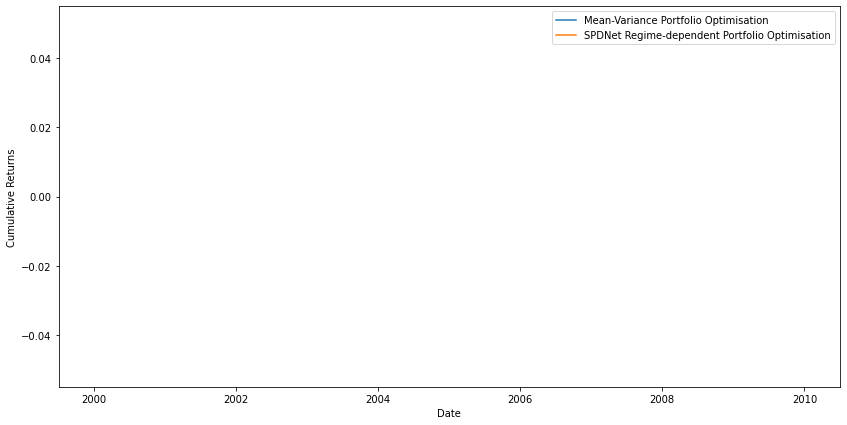

In [64]:
import matplotlib.pyplot as plt

# Plotting the performance
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, cumulative_portfolio_returns, label='Mean-Variance Portfolio Optimisation')
plt.plot(test_df.index, cumulative_returns, label='SPDNet Regime-dependent Portfolio Optimisation')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
